In [1]:
TRAIN_TFRECORD = '../data/cifar10-train.tfrecord'
SCALING = 'linear'
FRACTION = 5
TOTAL_SAMPLES = 30000
LABELED_SAMPLES = '10:20:30:40:100:250:1000:4000'
SEED = 12345
OUTPUT_DIR = '../data/cifar10-30000-linear-5'
NAME = 'cifar10'

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as pl

from tqdm import tqdm
from itertools import count
from pathlib import Path

np.random.seed(SEED)

In [3]:
def get_class(serialized_example):
    return tf.parse_single_example(serialized_example, features={'label': tf.FixedLenFeature([], tf.int64)})['label']

dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD).map(get_class)
it = dataset.make_one_shot_iterator().get_next()
class_ids = []
try:
    with tf.Session() as session:
        for n in tqdm(count()):
            result = session.run(it)
            class_ids.append(result)
except tf.errors.OutOfRangeError:
    pass



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


50000it [00:10, 4709.35it/s]


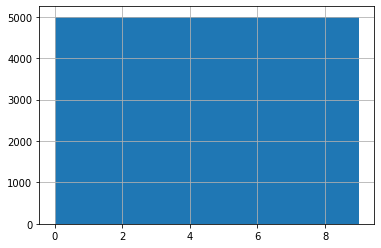

In [4]:
df = pd.DataFrame({'class_id': class_ids})
df.class_id.hist()

In [5]:
n_classes = df.class_id.max() + 1
class_order = np.arange(n_classes)
np.random.shuffle(class_order)

if SCALING == 'linear':
    num_samples = np.linspace(1, 1 / FRACTION, num=n_classes)
else:
    raise ValueError(f'Dont understand scaling == {linear}') 
    
num_samples *= TOTAL_SAMPLES / np.sum(num_samples)
num_samples = num_samples[class_order].astype(np.int64)
num_samples

print(num_samples)

if any(df.groupby('class_id').size().values < num_samples):
    raise ValueError('Cannot fullfill samples')

[5000 1888 3666 1000 2333 3222 4555 1444 2777 4111]


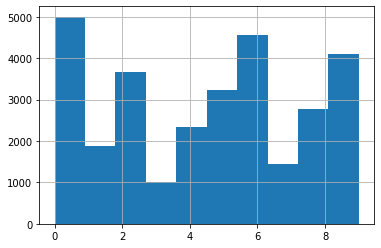

In [6]:
def sample(group):
    class_id, = group.class_id.unique()
    n = num_samples[class_id]
    return group.sample(n=num_samples[class_id], replace=False)
    
selection = df.reset_index().groupby('class_id').apply(sample).reset_index(drop=True)
selection.class_id.hist()

In [7]:
dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD)
it = dataset.make_one_shot_iterator().get_next()
data = []
try:
    with tf.Session() as session:
        for n in tqdm(count()):
            result = session.run(it)
            data.append(result)
except tf.errors.OutOfRangeError:
    pass

50000it [00:08, 6158.12it/s]


In [8]:
output_dir = Path(OUTPUT_DIR) / 'SSL2'
output_dir.mkdir(exist_ok=True, parents=True)

def write_selection(selection, path):
    indices = selection.index.values.copy()
    np.random.shuffle(indices)

    with tf.python_io.TFRecordWriter(str(path)) as writer:
        for index in tqdm(indices):
            writer.write(data[index])
        
write_selection(selection, output_dir / f'{NAME}-unlabel.tfrecord')

100%|██████████| 29996/29996 [00:00<00:00, 127090.75it/s]


In [9]:
for labelled_samples in LABELED_SAMPLES.split(':'):
    n = int(labelled_samples) // n_classes
    for seed in range(6):
        rgen = np.random.RandomState(seed)
        selection = df.reset_index().groupby('class_id').apply(
            lambda d: d.sample(n=n, replace=False, random_state=rgen)).reset_index(drop=True)
        write_selection(selection, output_dir / f'{NAME}.{seed}@{labelled_samples}-label.tfrecord')

100%|██████████| 4000/4000 [00:00<00:00, 137327.93it/s]
